<a href="https://colab.research.google.com/github/SanketJadhav7d3/Future-Frame-Prediction/blob/main/GAN_for_future_prediction_Korean_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/drive/MyDrive/GAN DATASET/walking.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/GAN DATASET/walking.zip
  inflating: /content/dataset/person01_walking_d1_uncomp.avi  
  inflating: /content/dataset/person01_walking_d2_uncomp.avi  
  inflating: /content/dataset/person01_walking_d3_uncomp.avi  
  inflating: /content/dataset/person01_walking_d4_uncomp.avi  
  inflating: /content/dataset/person02_walking_d1_uncomp.avi  
  inflating: /content/dataset/person02_walking_d2_uncomp.avi  
  inflating: /content/dataset/person02_walking_d3_uncomp.avi  
  inflating: /content/dataset/person02_walking_d4_uncomp.avi  
  inflating: /content/dataset/person03_walking_d1_uncomp.avi  
  inflating: /content/dataset/person03_walking_d2_uncomp.avi  
  inflating: /content/dataset/person03_walking_d3_uncomp.avi  
  inflating: /content/dataset/person03_walking_d4_uncomp.avi  
  inflating: /content/dataset/person04_walking_d1_uncomp.avi  
  inflating: /content/dataset/person04_walking_d2_uncomp.avi  
  inflating: /content/dataset/person04_walking_d3_uncomp.avi 

In [ ]:
!pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 11.3 MB/s eta 0:00:00


In [ ]:
import os

import pandas as pd

import torch
import torchvision
from torchvision.io import read_video
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

In [ ]:
def split_video(video_tensor):
  # frames X height X width X channel
  frames, height, width, channel = video_tensor.shape
  total_segs = frames // 12
  slices = torch.reshape(video_tensor[:total_segs*12], (total_segs, 12, height, width, channel))
  return slices

In [ ]:
video, audio, info = torchvision.io.read_video('/content/dataset/person01_walking_d1_uncomp.avi')


/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [ ]:
slices = split_video(video)
one_slice = slices[0]

slices.shape, one_slice.shape

(torch.Size([46, 12, 120, 160, 3]), torch.Size([12, 120, 160, 3]))

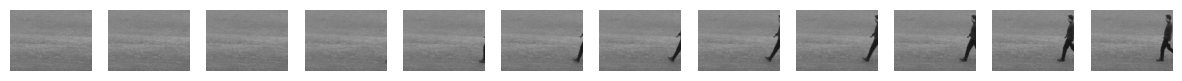

In [ ]:
plt.figure(figsize=(15, 3))

for i in range(12):
  plt.subplot(1, 12, i + 1)
  plt.imshow(one_slice[i])
  plt.axis('off')

In [ ]:
# rough code

meta_data = pd.DataFrame({
  'file path': [],
  'total frames': [],
  'total slices': []
})

file_paths = []
total_frames = []
total_slices = []

for file_name in os.listdir('/content/dataset'):
  file_path = os.path.join('/content/dataset', file_name)
  video, audio, info = read_video(file_path)
  file_paths.append(file_path)
  total_frames.append(video.shape[0])
  total_slices.append(video.shape[0] // 12)

meta_data['file path'] = file_paths
meta_data['total frames'] = total_frames
meta_data['total slices'] = total_slices

In [ ]:
meta_data['total frames'].sum()

65795

In [ ]:
# index to slice mapping

idx_to_slices = pd.DataFrame({
  'global idx': [], # global idx i.e. considering all videos
  'file path': [],
  'local idx': []   # to get the local slice number to the video
})

last_index = 0
for idx, row in meta_data.iterrows():
  total_slice = row['total slices']
  file_path = row['file path']
  indexes = [int(i) for i in range(last_index, last_index+total_slice)]
  local_indexes = list(range(0, total_slice))
  last_index = last_index+total_slice
  idx_to_slices = pd.concat([idx_to_slices, pd.DataFrame({'global idx': indexes, 'file path': [file_path] * len(indexes),
                                                          'local idx': local_indexes})])
idx_to_slices.set_index(['global idx'], inplace=True)

In [ ]:
idx_to_slices

,file path,local idx
global idx,,
0.0,/content/dataset/person11_walking_d3_uncomp.avi,0.0
1.0,/content/dataset/person11_walking_d3_uncomp.avi,1.0
2.0,/content/dataset/person11_walking_d3_uncomp.avi,2.0
3.0,/content/dataset/person11_walking_d3_uncomp.avi,3.0
4.0,/content/dataset/person11_walking_d3_uncomp.avi,4.0
...,...,...
5438.0,/content/dataset/person01_walking_d3_uncomp.avi,74.0
5439.0,/content/dataset/person01_walking_d3_uncomp.avi,75.0
5440.0,/content/dataset/person01_walking_d3_uncomp.avi,76.0


In [ ]:
idx_to_slices.to_csv('idx_to_slices.csv', index=False)

In [ ]:

class HumanMotionDataset(Dataset):
  def __init__(self, data_csv, transform=None, is_val=False):
    self.data_csv = data_csv
    self.transform = transform
    self.is_val = is_val

  def __len__(self):
    return self.data_csv.shape[0]

  def __getitem__(self, idx):
    file_path = self.data_csv.iloc[idx, 0]
    local_idx = int(self.data_csv.iloc[idx, 1])
    # read file
    video, audio, info = read_video(file_path)
    slices = split_video(video)
    slice_ = slices[local_idx]

    # change into the format frames * channels * height * width
    slice_ = slice_.permute(0, 3, 1, 2)

    if self.transform:
      slice_ = self.transform(slice_)

    return slice_[:6], slice_[6:]

In [ ]:
dataset = HumanMotionDataset(idx_to_slices, train_transform)

In [ ]:
input, output = dataset[5023]

/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([6, 3, 64, 64])


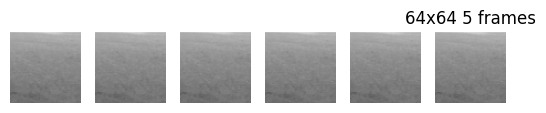

In [ ]:

for i in range(6):
  plt.subplot(1, 6, i + 1)
  plt.imshow(input[i].permute(1, 2, 0).numpy())
  plt.axis('off')
plt.title("64x64 5 frames")
print(input.shape)

torch.Size([6, 3, 64, 64])


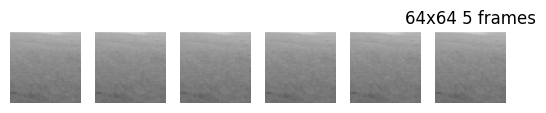

In [ ]:

for i in range(6):
  plt.subplot(1, 6, i + 1)
  plt.imshow(output[i].permute(1, 2, 0).numpy())
  plt.axis('off')

plt.title("64x64 5 frames")
print(output.shape)

# Data Loader

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=12, shuffle=False)

In [ ]:
inputs, outputs = next(iter(train_dataloader))

outputs.shape

torch.Size([12, 6, 3, 64, 64])

Text(0.5, 1.0, '64x64 5 frames')

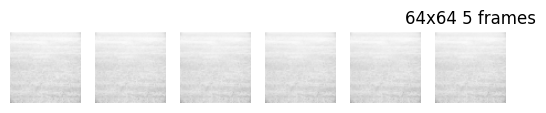

In [ ]:
for i in range(6):
  plt.subplot(1, 6, i + 1)
  plt.imshow(outputs[11][i].permute(1, 2, 0).numpy())
  plt.axis('off')

plt.title("64x64 5 frames")

In [ ]:
def visualize_batch(batch):
  inputs, outputs = batch
  rows = 12
  cols = 12
  fig, axes = plt.subplots(rows, cols, figsize=(14, 14))

  for i in range(rows):
    for j in range(6):
      img = inputs[i][j].permute(1, 2, 0).numpy()
      axes[i, j].imshow(img)
      axes[i, j].axis('off')
    for j in range(6, 12) :
      img = outputs[i][j-6].permute(1, 2, 0).numpy()
      axes[i, j].imshow(img)
      axes[i, j].axis('off')

  fig.suptitle("One batch")

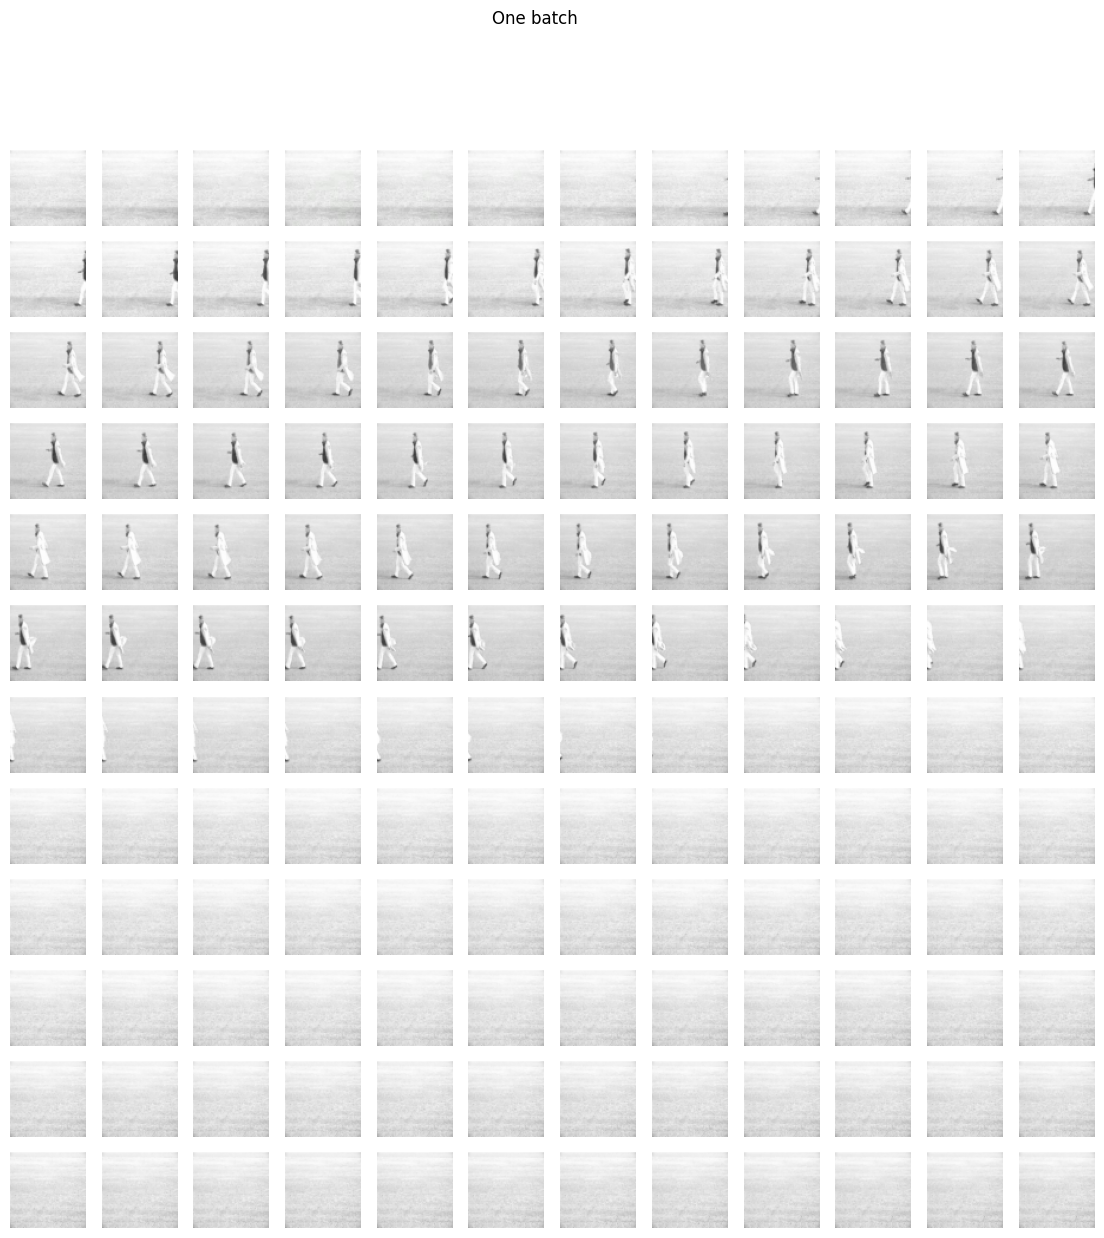

In [ ]:
visualize_batch(next(iter(train_dataloader)))

# some experiments

In [ ]:
# inputs, outputs = next(iter(train_dataloader))
# input = inputs[0]

input = torch.rand((1, 3, 6, 64, 64))

layers = nn.Sequential(
    nn.Conv3d(
      in_channels=3,
      out_channels=128,
      kernel_size=(1, 7, 7),
      stride=(1, 1, 1),
    ),
    nn.Conv3d(
      in_channels=128,
      out_channels=128,
      kernel_size=(1, 3, 3),
      stride=(1, 1, 1),
    ),
    nn.Conv3d(
      in_channels=128,
      out_channels=256,
      kernel_size=(1, 3, 3),
      stride=(1, 1, 1),
    ),


    nn.Conv3d(
      in_channels=256,
      out_channels=256,
      kernel_size=(1, 3, 3),
      stride=(1, 1, 1),
      padding='same'
    ),
    nn.Conv3d(
      in_channels=256,
      out_channels=256,
      kernel_size=(1, 3, 3),
      stride=(1, 1, 1),
      padding='same'
    ),


    nn.ConvTranspose3d(
      in_channels=256,
      out_channels=128,
      kernel_size=(1, 3, 3),
      stride=(1, 1, 1)
    ),
    nn.ConvTranspose3d(
      in_channels=128,
      out_channels=128,
      kernel_size=(1, 3, 3),
      stride=(1, 1, 1)
    ),
    nn.ConvTranspose3d(
      in_channels=128,
      out_channels=3,
      kernel_size=(1, 7, 7),
      stride=(1, 1, 1)
    ),
)

# input = input.unsqueeze(0)
# input = input.permute(0, 2, 1, 3, 4)

# first dim = batch size
# second dim = channel of single input plane
# third dim = number of input planes
# fourth dim = height
# fifth dim = width
input.shape

torch.Size([1, 3, 6, 64, 64])

In [ ]:
sample = torch.rand(1, 3, 6, 64, 64)

print(sample.shape)

out = nn.Conv3d(
      in_channels=3,
      out_channels=128,
      kernel_size=(1, 7, 7),
      stride=(1, 2, 2),
      padding=(0, 3, 3)
    )(sample)

print(out.shape)

nn.ConvTranspose3d(
      in_channels=128,
      out_channels=3,
      kernel_size=(1, 7, 7),
      stride=(1, 2, 2),
      padding=(0, 3, 3)
    )(out).shape

torch.Size([1, 3, 6, 64, 64])
torch.Size([1, 128, 6, 32, 32])


torch.Size([1, 3, 6, 63, 63])

In [ ]:
# first dim : batch size
# second dim : channels (number of kernels used)
# third dim : depth (convolution across depth)
# fourth dim : height (convolutional across height)
# fifth dim : width (convolutional across width duh)


layers(input).shape

torch.Size([1, 3, 6, 64, 64])

# Model

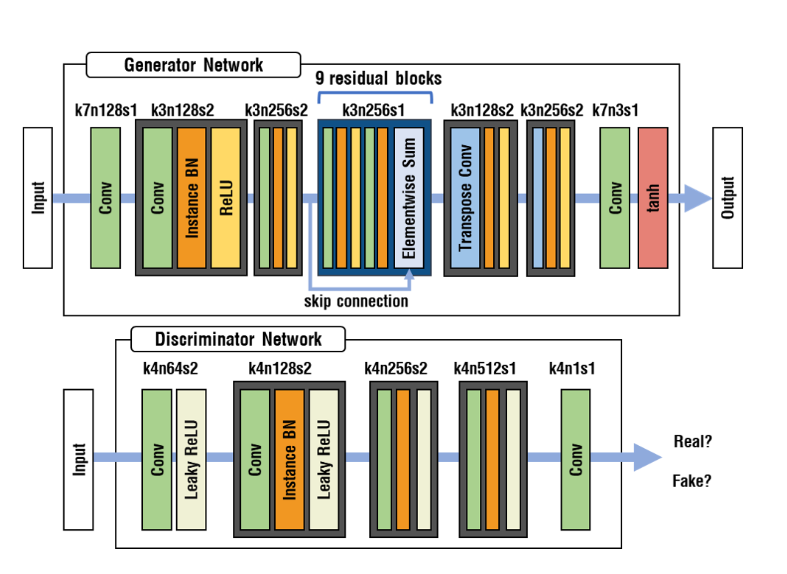



In [ ]:


def conv_3d_block(parameters):
  return nn.Sequential(
    nn.Conv3d(
      in_channels=parameters['in'],
      out_channels=parameters['out'],
      kernel_size=parameters['kernel'],
      stride=parameters['stride'],
    ),
    nn.BatchNorm3d(parameters['out']),
    nn.ReLU(),
  )

def up_conv_3d_block(parameters):
  return nn.Sequential(
    nn.ConvTranspose3d(
      in_channels=parameters['in'],
      out_channels=parameters['out'],
      kernel_size=parameters['kernel'],
      stride=parameters['stride'],
    ),
    nn.BatchNorm3d(parameters['out']),
    nn.ReLU(),
  )

class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.input = nn.Conv3d(
      in_channels=3,
      out_channels=128,
      kernel_size=(1, 3, 3),
      stride=(1, 2, 2),
    )

    self.output = nn.ConvTranspose3d(
        in_channels=256,
        out_channels=3,
        kernel_size=(1, 3, 3),
        stride=(1, 1, 1),
    )

    self.encoderLayers = {
        0: {
          'in': 128,
          'out': 128,
          'kernel': (1, 3, 3),
          'stride': (1, 2, 2),
        },
        1: {
          'in': 128,
          'out': 256,
          'kernel': (1, 3, 3),
          'stride': (1, 2, 2),
        },
        2: {
          'in': 256,
          'out': 256,
          'kernel': (1, 3, 3),
          'stride': (1, 1, 1),
        },
        3: {
          'in': 256,
          'out': 256,
          'kernel': (1, 3, 3),
          'stride': (1, 1, 1),
        },
    }

    self.decoderLayers = {
        0: {
          'in': 256,
          'out': 128,
          'kernel': (1, 3, 3),
          'stride': (1, 2, 2),
        },
        1: {
          'in': 128,
          'out': 256,
          'kernel': (1, 3, 3),
          'stride': (1, 2, 2),
        }
    }

    self.encoder = nn.Sequential()
    self.decoder = nn.Sequential()


    for key, value in self.encoderLayers.items():
      self.encoder.add_module(
        'down_'+str(key), conv_3d_block(value)
      )

    for key, value in self.decoderLayers.items():
      self.decoder.add_module(
        'up_'+str(key), up_conv_3d_block(value)
      )


  def forward(self, x):
    x = self.input(x)
    x = self.encoder(x)
    x = self.decoder(x)
    x = self.output(x)
    return x

/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


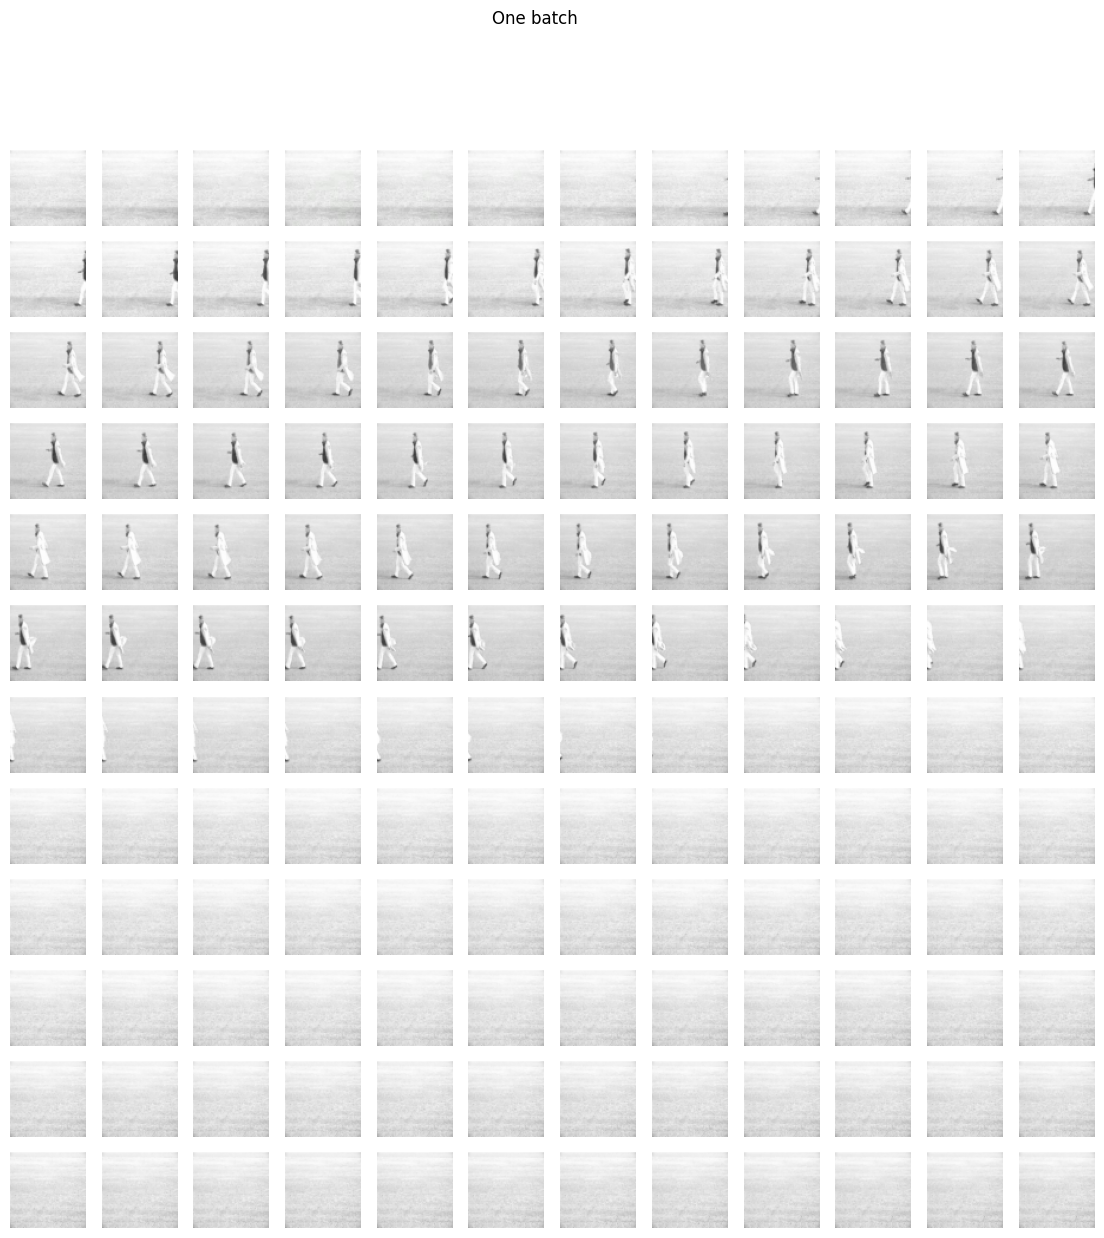

In [ ]:
batch = next(iter(train_dataloader))

visualize_batch(batch)

In [ ]:
inputs, outputs = batch

inputs.shape, outputs.shape

(torch.Size([12, 6, 3, 64, 64]), torch.Size([12, 6, 3, 64, 64]))

In [ ]:
net_g = Generator()

net_g.encoder

Sequential(
  (down_0): Sequential(
    (0): Conv3d(128, 128, kernel_size=(1, 3, 3), stride=(1, 2, 2))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (down_1): Sequential(
    (0): Conv3d(128, 256, kernel_size=(1, 3, 3), stride=(1, 2, 2))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (down_2): Sequential(
    (0): Conv3d(256, 256, kernel_size=(1, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (down_3): Sequential(
    (0): Conv3d(256, 256, kernel_size=(1, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [ ]:
net_g(inputs.permute(0, 2, 1, 3, 4).float()).shape

torch.Size([12, 3, 6, 17, 17])